In [1]:
# If this notebook is in a subdirectory of the project's root,
# update the PYTHONPATH to be able to import as usual
import os, sys
project_root = os.path.dirname(os.path.abspath(''))
sys.path.append(project_root)

In [2]:
# Standard Imports
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt

# Project Imports
from train import setup
from parallelize import load_args
from utils import save_path
from metrics import calc_herr

In [3]:
hs = np.array([0.8, 0.4, 0.2, 0.1, 0.05])
methods = ['euler-forw', 'euler-symp', 'midpoint']

In [4]:
# Train all missing models (not recommended on CPU)
# from joblib import Parallel, delayed
# from model.args import custom_product
# from train import train_if_missing
# args_list = list(load_args(base_args=default_args, custom_prod=custom_product(h_list=hs, loss_type_list=methods)))
# _ = Parallel(n_jobs=-1, verbose=True)(delayed(train_if_missing)(args, save_dir_prefix='/results/experiment-') for args in args_list)

## Outsource some of the calculations before plotting

In [5]:
def plot_herr(axes, args, legend_loc='lower right', annotate_slopes=False):
    # Plot grey guides of y = px, indicating errors of order p 
    #axes.loglog(hs, hs, '--', color='lightgrey', label=r'$\varepsilon = h$')  # p = 1
    #axes.loglog(hs, hs**2, '--', color='lightgrey', label=r'$\varepsilon = h^2$')  # p = 2
    axes.loglog(hs, hs, '--', color='lightgrey')
    axes.loglog(hs, hs**2, '--', color='lightgrey')
    
    # Plot errors for each method
    for method in methods:
        err = calc_herr(args | {'loss_type': method}, hs)
        axes.errorbar(hs, err[:, 0], yerr=err[:, 1], fmt='o-',
                      label=r'$\varepsilon_H$ ' + print_method[method])
    
    # Plot errors for the corrected symplectic Euler
    err = calc_herr(args | {'loss_type': 'euler-symp'}, hs, corrected=True)
    axes.errorbar(hs, err[:, 0], yerr=err[:, 1], fmt='o-',
                  label=r'$\varepsilon_H$ corrected ' + print_method['euler-symp'])

    axes.set_xlabel("Discretization Step $h$")  # possible kwargs: fontsize=14
    axes.set_ylabel(r"Error $\varepsilon$")  # possible kwargs: rotation=0, fontsize=14
    axes.set_xticks(hs)
    axes.set_xticklabels(map(str, hs))
    #axes.set_title(f"{print_name[args.name]}: Hamiltonian Error \n (over the relevant phase space region)", pad=10)
    axes.set_title(f"{print_name[args.name]}: Hamiltonian Error")#, pad=10) 
    
    if annotate_slopes:
        axes.text(0.14, 0.14-0.02, r'$\varepsilon \in \mathcal O(h)$',
                  color='grey', rotation=15, verticalalignment='bottom', horizontalalignment='center')
        axes.text(0.15, 0.15**2-0.005, r'$\varepsilon \in \mathcal O(h^2)$',
                  color='grey', rotation=25, verticalalignment='bottom', horizontalalignment='center')
    
    legend = axes.legend(loc=legend_loc)
    legend.get_frame().set_facecolor('0.9')  # fill the legend dark grey
    legend.get_frame().set_linewidth(0.0)  # remove the black border

## Start Plotting Code

In [6]:
from visualize import *
mpl.rcParams.update(params)
%matplotlib inline

In [7]:
# TESTING: The below needs only one method (but all h's) for one problem
#calc_herr(default_args | {'loss_type': 'euler-symp'})
# TESTING: The below needs all methods and all h's of one problem
#fig, axes = plt.subplots() 
#plot_herr(axes, default_args | {'name': 'pendulum'}, annotate_slopes=True)
# OR
#plot_herr(axes, default_args | {'name': 'pendulum'})

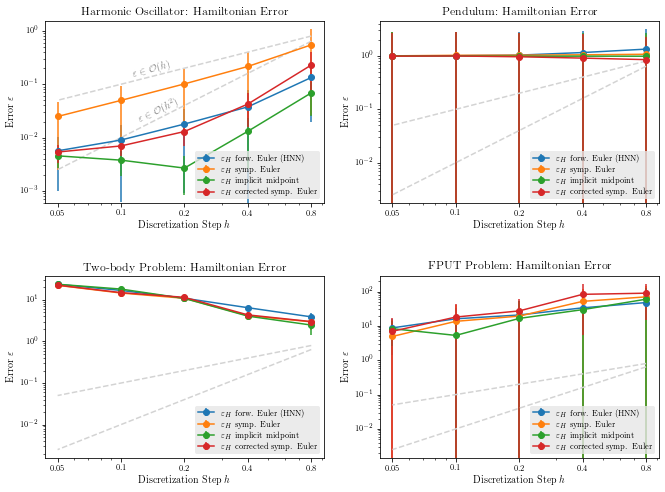

In [10]:
# PLOT ALL TOGETHER
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(11, 13*golden_ratio))
fig.subplots_adjust(wspace=0.2, hspace=0.4)

plot_herr(ax1, default_args | {'name': 'spring'}, annotate_slopes=True)
plot_herr(ax2, default_args | {'name': 'pendulum'})
plot_herr(ax3, default_args | {'name': 'twobody'})
plot_herr(ax4, default_args | {'name': 'fput'})

fig.savefig("hamiltonian-error.pdf", format='pdf', bbox_inches='tight')

## Old code

Used to also plot Hamiltonian error landscape in phase space, for 2D systems like spring/pendulum.

In [9]:
if False:
    from model.data import get_t_eval

    t_span = (0, 300)
    t_eval = get_t_eval(t_span, args.h)

    # Use RK45 with rtol of 1e-9 to have RK45 effectively yield the true flow of a vector field 
    kwargs = {'t_eval': t_eval, 'rtol': 1e-9, 'method': 'RK45'}

    # INTEGRATE MODEL
    static_y0 = args.data_class.static_initial_value()

    pred_field = get_predicted_vector_field(model, args)
    pred_traj_rk45 = integrate_model_rk45(model, t_span, static_y0, **kwargs)
    pred_traj_custom, t_custom = integrate_model_custom(model, t_span, static_y0, args)

    scheme = choose_scheme(args.loss_type)(args)
    corrected_model = CorrectedHNN.get(model, scheme, args.h)
    field_corrected = get_predicted_vector_field(corrected_model, args)
    pred_traj_corrected = integrate_model_rk45(corrected_model, t_span, static_y0, **kwargs)

    # Calculate the Hamiltonian along the trajectory
    #H = model.forward(torch.tensor(pred_traj_rk45, dtype=torch.float32)).data.numpy()

    # TRUE TRAJECTORY FOR REFERENCE
    data_loader = args.data_class(args.h, args.noise)
    exact_field = data_loader.get_analytic_field()
    exact_traj, _ = data_loader.get_trajectory(t_span=t_span, y0=static_y0)
    # dataset = data_loader.get_dataset(seed=args.seed, samples=3000, test_split=0.05)  # (3000, 2, 2)
    # dataset_plot(ax[2], dataset['coords'][:, 0], dataset['test_coords'][:, 0], args, "Dataset for ...")

    # Calculate the initial Hamiltonian = Hamiltonian at all times of true trajectory
    #Hy0 = data_loader.bundled_hamiltonian(static_y0)

    # Calculate the respective errors
    #traj_error = np.linalg.norm(pred_traj_rk45 - exact_traj, axis=1)
    #H_error = np.abs(H - Hy0)

    fig = plt.figure(figsize=(28, 6), facecolor='white', dpi=300)
    ax = [fig.add_subplot(1, 5, i + 1, frameon=True) for i in range(5)]  # kwarg useful sometimes: aspect='equal'

    title_true = f"True Trajectory\n (Integrated with RK45)"
    phase_space_plot(ax[0], exact_field, exact_traj, title_true, args)

    title_pred = f"Symplectic HNN: $h = {args.h}, t_f = {t_span[1]}$\n Trained with {args.loss_type}, Integrated with RK45"
    phase_space_plot(ax[1], pred_field, pred_traj_rk45, title_pred, args)

    title_custom = f"Symplectic HNN: $h = {args.h}, t_f = {t_span[1]}$\n Trained with {args.loss_type}, Integrated with {args.loss_type}"
    phase_space_plot(ax[2], pred_field, pred_traj_custom, title_custom, args)

    title_corr = f"Corrected Trajectory"
    phase_space_plot(ax[3], field_corrected, pred_traj_corrected, title_corr, args)

    lim = len(t_eval)//3
    title_both = f"$p$ Coordinate vs. Time \n (Note: smaller t-interval for more clarity)"
    axes = plt
    axes.plot(t_eval[:lim], exact_traj[:lim, 0], label='Exact')
    axes.plot(t_eval[:lim], pred_traj_rk45[:lim, 0], label='Pred RK45')
    axes.plot(t_custom[:lim], pred_traj_custom[:lim, 0], label=f'Pred {args.loss_type}')
    axes.plot(t_eval[:lim], pred_traj_corrected[:lim, 0], label='Pred Corrected')
    axes.set_xlabel("$t$", fontsize=14)
    axes.set_ylabel("$p$", rotation=0, fontsize=14)
    axes.legend()
    axes.set_title(title_both)

    #title_trajerror = f"Deviation (norm of error) of the two trajectories \n (Over full timespan, $t_f = {t_span[1]}$)"
    #plot_helper(ax[3], t_eval, traj_error, title_trajerror)

    # TODO Eventually fix the scientific notation for the axis scale, see this question:
    #       https://stackoverflow.com/questions/42656139/set-scientific-notation-with-fixed-exponent-and-significant-digits-for-multiple
    #title3 = r"Deviation of the Hamiltonian: $|H(y(t)) - H(y_0)|$"
    #plot_helper(ax[3], t_eval, H_error, title3)

    # Old code to investigate individual
    #ax[2].plot(t_eval, exact_traj[:, 0], color='blue')
    #ax[2].plot(t_eval, pred_traj_rk45[:, 0], color='red')

    # SAVE FIGURE USING USUAL PATH
    plt.savefig(save_path(args, ext='pdf'))